In [1]:
# Create a publication-ready architecture diagram (SVG + PDF) for the provided GAT model
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
from matplotlib.patches import ConnectionPatch
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42  # embed fonts
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.size'] = 10

def add_box(ax, xy, w, h, text, fc="white", ec="black", linestyle="-", lw=1.2, fontsize=10):
    x, y = xy
    box = FancyBboxPatch((x, y), w, h,
                         boxstyle="round,pad=0.02,rounding_size=4",
                         fc=fc, ec=ec, lw=lw, linestyle=linestyle)
    ax.add_patch(box)
    ax.text(x + w/2, y + h/2, text, ha="center", va="center", fontsize=fontsize)
    return box

def add_arrow(ax, start_xy, end_xy, text=None, fontsize=9):
    ax.annotate("",
                xy=end_xy, xycoords='data',
                xytext=start_xy, textcoords='data',
                arrowprops=dict(arrowstyle="->", lw=1.1))
    if text:
        midx = (start_xy[0] + end_xy[0]) / 2
        midy = (start_xy[1] + end_xy[1]) / 2
        ax.text(midx, midy + 0.12, text, ha="center", va="bottom", fontsize=fontsize)
        
# Canvas
fig_w, fig_h = 12, 7
fig, ax = plt.subplots(figsize=(fig_w, fig_h))
ax.set_xlim(0, 12)
ax.set_ylim(0, 7)
ax.axis("off")

# Layout coordinates
x0 = 0.5
y_mid = 3.5
box_w = 2.1
box_h = 0.8
gap = 0.6

# Inputs
in_node = add_box(ax, (x0, y_mid+1.2), box_w, box_h, "node_features\n(N, 4 one-hot)")
in_adj  = add_box(ax, (x0, y_mid-1.6), box_w, box_h, "adj_matrix\n(N, N) > 0")
add_arrow(ax, (x0+box_w, y_mid+1.6), (x0+box_w+0.6, y_mid+1.6))
add_arrow(ax, (x0+box_w, y_mid-1.2), (x0+box_w+0.6, y_mid-1.2), text="to edge_index")
ax.text(x0+box_w+0.7, y_mid-1.2, "adj > 0 → indices", va="center", fontsize=9)

# Optional embedding (dashed)
emb_x = x0 + box_w + 1.0
emb = add_box(ax, (emb_x, y_mid+1.2), box_w, box_h,
              "Optional node embed\nLinear 4 → embed_dim",
              linestyle="--")
add_arrow(ax, (x0+box_w+0.6, y_mid+1.6), (emb_x, y_mid+1.6))
ax.text(emb_x+box_w/2, y_mid+2.1, "Used if embed_dim is not None", ha="center", fontsize=8)

# Edge index computation box
edge_x = emb_x
edge = add_box(ax, (edge_x, y_mid-1.6), box_w, box_h, "adj_matrix_to_edge_index\n(edge_index)")
add_arrow(ax, (x0+box_w+0.6, y_mid-1.2), (edge_x, y_mid-1.2))

# GAT stack header
gat_x = emb_x + box_w + 1.0
gat_header = add_box(ax, (gat_x, y_mid+1.9), 3.7, 0.6,
                     "Pre-norm GATv2 stack (heads=4, concat)", fc="#f0f4ff")
ax.text(gat_x+3.7/2, y_mid+2.7, "LayerNorm → GATv2Conv → Residual(+proj) → ReLU", ha="center", fontsize=9)

# Three GAT blocks
b_w, b_h = 3.7, 0.8
l1 = add_box(ax, (gat_x, y_mid+0.9), b_w, b_h,
             "Layer 1: in = 4 or embed_dim → out = 32 × 4 = 128\n(residual projection used)",
             fc="white")
l2 = add_box(ax, (gat_x, y_mid-0.1), b_w, b_h,
             "Layer 2: 128 → 64 × 4 = 256\n(residual projection used)", fc="white")
l3 = add_box(ax, (gat_x, y_mid-1.1), b_w, b_h,
             "Layer 3: 256 → 64 × 4 = 256\n(no projection)", fc="white")

# Arrows into GAT stack
# From embedding (or directly from node_features if no embed)
add_arrow(ax, (emb_x+box_w, y_mid+1.6), (gat_x, y_mid+1.6), text="node features")
add_arrow(ax, (edge_x+box_w, y_mid-1.2), (gat_x, y_mid-1.2), text="edge_index")

# Internal arrows within stack
add_arrow(ax, (gat_x+b_w/2, y_mid+1.7), (gat_x+b_w/2, y_mid+1.7-0.2))
add_arrow(ax, (gat_x+b_w/2, y_mid+0.9), (gat_x+b_w/2, y_mid+0.9-0.1))
add_arrow(ax, (gat_x+b_w/2, y_mid-0.1), (gat_x+b_w/2, y_mid-0.1-0.1))

# Global attentional pooling
pool_x = gat_x + b_w + 1.0
pool = add_box(ax, (pool_x, y_mid-0.1), 2.4, 1.0,
               "Global Attentional Aggregation\n(gate_nn: Linear→ReLU→Linear)\nOutput dim = 256",
               fc="#f6fff0")
add_arrow(ax, (gat_x+b_w, y_mid+0.3), (pool_x, y_mid+0.3), text="node embeddings (N, 256)")
ax.text(pool_x+1.2, y_mid+1.1, "batch=0 for all nodes", ha="center", fontsize=8)

# Combined MLP head
mlp_x = pool_x + 2.4 + 1.0
mlp = add_box(ax, (mlp_x, y_mid-0.2), 2.9, 1.2,
              "MLP head (combined_net)\n256 → 256 → 256 → 128\n(ReLU, Dropout=0.1)",
              fc="#fff7f0")
add_arrow(ax, (pool_x+2.4, y_mid+0.3), (mlp_x, y_mid+0.3), text="graph embedding (256)")

# Output
out_x = mlp_x + 2.9 + 0.8
out = add_box(ax, (out_x, y_mid+0.2), 


SyntaxError: unexpected EOF while parsing (2932489825.py, line 107)

In [ ]:
import numpy as np

In [2]:
from utils5 import *

In [3]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym
from gymnasium import spaces
import torch_geometric.nn as geom_nn
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

class CustomGCNN(BaseFeaturesExtractor):
    """
    Pre-norm GATv2 stack with residual projections, optional node-feature
    embedding, attention pooling, and a scalar MLP.
    """

    def __init__(
        self,
        observation_space: gym.spaces.Dict,
        features_dim: int = 128,
        *,                       # force keyword use
        embed_dim: 'int | None' = 16,   # ← set to e.g. 16 to enable
    ):
        super().__init__(observation_space, features_dim)

        # ---------- embedding (optional) ----------------------------------
        in_node_dim = observation_space["node_features"].shape[1]  # =4 (one-hot)
        self.node_embed: 'nn.Module | None' = None
        if embed_dim is not None:
            # one-hot (N,4) · W(4,embed_dim)  →  (N,embed_dim)
            self.node_embed = nn.Linear(in_node_dim, embed_dim, bias=False)
            in_node_dim = embed_dim                      # GNN now sees embed_dim

        # ------------------- GATv2 stack (pre-norm) ---------------------
        layer_cfg = [(32, 4), (64, 4), (64, 4)]          # (out_dim, heads)
        self.gnn_layers = nn.ModuleList()
        cur_dim = in_node_dim

        for out_dim, heads in layer_cfg:
            out_channels = out_dim * heads               # concat=True
            conv = geom_nn.GATv2Conv(
                in_channels=cur_dim,
                out_channels=out_dim,
                heads=heads,
                concat=True,
                dropout=0.1,
            )
            norm = nn.LayerNorm(cur_dim)                 # pre-norm
            proj = (
                None
                if cur_dim == out_channels
                else nn.Linear(cur_dim, out_channels, bias=False)
            )
            self.gnn_layers.append(nn.ModuleDict({"conv": conv, "norm": norm, "proj": proj}))
            cur_dim = out_channels

        # ------------------- Global Attention pooling -------------------
        self.global_pool = geom_nn.GlobalAttention(
            gate_nn=nn.Sequential(
                nn.Linear(cur_dim, cur_dim // 2),
                nn.ReLU(),
                nn.Linear(cur_dim // 2, 1),
            )
        )
        self.gcn_out_dim = cur_dim

        # ------------------- Scalar branch ------------------------------
        scalar_dim = observation_space["scalars"].shape[0]
        self.scalar_net = nn.Sequential(
            nn.Linear(scalar_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
        )

        # ------------------- Fusion head --------------------------------
        self.combined_net = nn.Sequential(
            nn.Linear(self.gcn_out_dim + 128, features_dim),
            nn.ReLU(),
        )

    # ------------------------------------------------------------------
    def adj_matrix_to_edge_index(self, adj_matrix: th.Tensor) -> th.Tensor:
        row, col = th.nonzero(adj_matrix > 0, as_tuple=True)
        return th.stack([row, col], dim=0)

    # ------------------------------------------------------------------
    def _encode_graph(self, x: th.Tensor, adj: th.Tensor) -> th.Tensor:
        if self.node_embed is not None:                  # optional embedding
            x = self.node_embed(x)

        edge_index = self.adj_matrix_to_edge_index(adj)

        for layer in self.gnn_layers:
            h = layer["conv"](layer["norm"](x), edge_index)   # pre-norm
            res = x if layer["proj"] is None else layer["proj"](x)
            x = F.relu(res + h)                               # residual + act

        batch = th.zeros(x.size(0), dtype=th.long, device=x.device)
        return self.global_pool(x, batch)

    # ------------------------------------------------------------------
    def process_graph(self, node_features: th.Tensor, adj_matrix: th.Tensor) -> th.Tensor:
        if adj_matrix.dim() == 3:  # batched
            outs = [
                self._encode_graph(node_features[i], adj_matrix[i])
                for i in range(adj_matrix.size(0))
            ]
            return th.stack(outs)
        return self._encode_graph(node_features, adj_matrix)

    # ------------------------------------------------------------------
    def forward(self, observation):
        device = next(self.parameters()).device

        node_features = th.as_tensor(observation["node_features"], dtype=th.float32, device=device)
        adj_matrix    = th.as_tensor(observation["adj_matrix"],    dtype=th.float32, device=device)
        scalar_obs    = th.as_tensor(observation["scalars"],       dtype=th.float32, device=device)

        graph_emb = self.process_graph(node_features, adj_matrix)
        if graph_emb.dim() == 3:                        # (B,1,D) -> (B,D)
            graph_emb = graph_emb.view(graph_emb.size(0), -1)

        if scalar_obs.dim() == 1:                       # ensure batch dim
            scalar_obs = scalar_obs.unsqueeze(0)
        scalar_emb = self.scalar_net(scalar_obs)

        x = th.cat([graph_emb, scalar_emb], dim=1)
        return self.combined_net(x)



In [5]:
max_nodes = 100

observation_space = spaces.Dict({
    "node_features": spaces.Box(low=0, high=1, shape=(max_nodes, 4), dtype=np.float32),  # 4 node features (one-hot encoded)
    "adj_matrix": spaces.Box(low=0, high=1, shape=(max_nodes, max_nodes), dtype=np.float32),  # Adjacency matrix
    "scalars": spaces.Box(low=0, high=1000, shape=(3,), dtype=np.float32)  # Scalar values: num_inputs, num_outputs, num_nodes
})        

Simple test

In [ ]:
import torch
from torch import randn

B, N, D = 4, 10, 4          # 4 node‑feature channels
obs = {
    "node_features": randn(B, N, D),
    "adj_matrix":    (torch.rand(B, N, N) > 0.7).float(),
    "scalars":       randn(B, 3),          # 3‑dim scalar vector
}

feat_extractor = CustomGCNN(observation_space, features_dim=128)
out = feat_extractor(obs)
print(out.shape)            # -> torch.Size([4, 128])



Learning test on size classification problem overfitting

In [ ]:
# -----------------------------------------------------------
# 0.  Imports
# -----------------------------------------------------------
import random, numpy as np, networkx as nx, torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch import optim
import gymnasium as gym

# Your own helpers
# from your_module import resize_matrix, generate_one_hot_features_from_adj, CustomGCNN
# (Assuming CustomGCNN is already in scope)

# -----------------------------------------------------------
# 1.  Build a toy dataset that mimics your env observations
# -----------------------------------------------------------
max_nodes      = 10          # same as env
node_feat_dim  = 4
scalar_dim     = 3           # num_inputs, num_outputs, num_nodes
num_samples    = 128         # small, so we can over‑fit fast
label_threshold = 5          # graph with >5 nodes -> label 1 else 0

# -----------------------------------------------------------
# 1‑bis.  Connected‑DAG generator
# -----------------------------------------------------------
def random_connected_dag(n_nodes: int,
                         p_extra: float = 0.3) -> nx.DiGraph:
    """
    Return a weakly‑connected DAG with `n_nodes`.
    Strategy:
      1.  Randomly permute node order  (0‑based IDs).
      2.  Build a random *directed spanning tree*   (acyclic & connected):
            for each node j (1..n‑1) pick a predecessor i < j and add edge i→j.
      3.  Add extra forward edges (i<j) with probability `p_extra`,
          skipping edges that would duplicate an existing one.
    """
    order = list(range(n_nodes))
    random.shuffle(order)

    g = nx.DiGraph()
    g.add_nodes_from(order)

    # Step‑1 : spanning tree ensures connectivity
    for idx in range(1, n_nodes):
        dst = order[idx]
        src = random.choice(order[:idx])      # always "earlier" => no cycle
        g.add_edge(src, dst)

    # Step‑2 : optional extra acyclic edges
    for i_idx in range(n_nodes):
        for j_idx in range(i_idx + 1, n_nodes):
            if random.random() < p_extra:
                src, dst = order[i_idx], order[j_idx]
                if not g.has_edge(src, dst):
                    g.add_edge(src, dst)

    assert nx.is_directed_acyclic_graph(g)
    assert nx.is_weakly_connected(g)          # connected in undirected sense
    return g


class ToyGraphDataset(Dataset):
    def __init__(self, n_samples=128):
        self.observations, self.labels = [], []
        for _ in range(n_samples):
            n_nodes = random.randint(3, max_nodes)
            g       = random_connected_dag(n_nodes) 

            # Build observation exactly like env
            nodelist           = list(nx.topological_sort(g))
            adj_sparse         = nx.adjacency_matrix(g, nodelist=nodelist)
            adj_dense          = adj_sparse.toarray()
            adj_matrix         = resize_matrix(adj_dense, max_nodes)
            adj_matrix       = np.array(adj_matrix, dtype=np.float32)
            node_features      = generate_one_hot_features_from_adj(adj_sparse, pad_size=max_nodes)
            scalars            = np.array([0, 0, 0], dtype=np.float32)  # dummy num_inputs/outputs

            obs = {
                "node_features": node_features.astype(np.float32),
                "adj_matrix"   : adj_matrix.astype(np.float32),
                "scalars"      : scalars,
            }
            self.observations.append(obs)
            # Graph‑level label: 1 if > threshold nodes
            self.labels.append(float(n_nodes > label_threshold))

    def __len__(self):                return len(self.labels)
    def __getitem__(self, idx):       return self.observations[idx], self.labels[idx]

ds   = ToyGraphDataset(num_samples)
dl   = DataLoader(ds, batch_size=16, shuffle=True)

# -----------------------------------------------------------
# 2.  Define observation_space to instantiate extractor
# -----------------------------------------------------------
observation_space = gym.spaces.Dict({
    "node_features": gym.spaces.Box(0, 1, shape=(max_nodes, node_feat_dim), dtype=np.float32),
    "adj_matrix"   : gym.spaces.Box(0, 1, shape=(max_nodes, max_nodes),    dtype=np.float32),
    "scalars"      : gym.spaces.Box(0, 1000, shape=(scalar_dim,),          dtype=np.float32),
})

# -----------------------------------------------------------
# 3.  Wrap CustomGCNN with a simple classifier head
# -----------------------------------------------------------
feature_dim = 128
gnn = CustomGCNN(observation_space, features_dim=feature_dim)
model = nn.Sequential(
    gnn,
    nn.Linear(feature_dim, 1)     # binary classification
)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# -----------------------------------------------------------
# 4.  Training loop – should over‑fit quickly
# -----------------------------------------------------------
for epoch in range(20):
    total_loss, correct, total = 0., 0, 0
    for batch_obs, batch_y in dl:
        optimizer.zero_grad()
        logits = model(batch_obs).squeeze(1)           # [B]
        y      = torch.tensor(batch_y, dtype=torch.float32)
        loss   = criterion(logits, y)
        loss.backward(); optimizer.step()

        total_loss += loss.item() * len(y)
        preds       = (torch.sigmoid(logits) > 0.5).float()
        correct    += (preds == y).sum().item()
        total      += len(y)

    print(f'Epoch {epoch:02d} | loss {total_loss/total:.4f} | acc {correct/total:.3f}')

# Expected: accuracy climbs toward 1.000 within a few epochs,
# proving the network + preprocessing chain are functional.


In [ ]:
# -----------------------------------------------------------
# 1.  Evaluate model and bucket graphs
# -----------------------------------------------------------
import torch, networkx as nx, numpy as np

model.eval()
TP, FP, TN, FN = [], [], [], []

with torch.no_grad():
    for obs, y_true in ds:
        logit = model(obs).squeeze().item()
        prob  = torch.sigmoid(torch.tensor(logit)).item()
        y_pred = int(prob > 0.5)

        # ----- rebuild NX graph WITHOUT padding nodes ----------
        adj_dense = obs["adj_matrix"]            # 10×10
        # keep rows/cols that contain any edge
        mask = (adj_dense.sum(0) + adj_dense.sum(1)) > 0
        adj_trim = adj_dense[np.ix_(mask, mask)]

        # skip visualising graphs that end up empty (shouldn’t happen)
        if adj_trim.size == 0:
            continue

        g = nx.from_numpy_array(adj_trim, create_using=nx.DiGraph)
        bucket_item = (g, prob)

        if   y_true == 1 and y_pred == 1: TP.append(bucket_item)
        elif y_true == 0 and y_pred == 1: FP.append(bucket_item)
        elif y_true == 0 and y_pred == 0: TN.append(bucket_item)
        else:                              FN.append(bucket_item)

# -----------------------------------------------------------
# 2.  Visualise confusion‑matrix gallery
# -----------------------------------------------------------
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from math import ceil

max_per_cell = 6
buckets      = {"TP": TP, "FP": FP, "FN": FN, "TN": TN}
quad_pos     = {"TN": (0, 0), "FP": (0, 1),
                "FN": (1, 0), "TP": (1, 1)}
quad_color   = {"TP": "#e5ffea", "FP": "#ffe8e8",
                "FN": "#ffe8e8", "TN": "#e5e8ff"}

fig = plt.figure(figsize=(9, 9))
fig.suptitle("Classifier outcomes", fontsize=16, y=0.98)
outer = gridspec.GridSpec(2, 2, wspace=0.15, hspace=0.15)

for quad, graphs in buckets.items():
    r, c  = quad_pos[quad]
    cell  = outer[r, c]

    # background + quadrant label
    ax_bg = plt.Subplot(fig, cell);  ax_bg.axis("off")
    ax_bg.add_patch(
        patches.Rectangle((0, 0), 1, 1,
                          transform=ax_bg.transAxes,
                          color=quad_color[quad], alpha=0.35, zorder=-1))
    ax_bg.text(0.5, 1.02, f"{quad}  (n={len(graphs)})",
               transform=ax_bg.transAxes, ha="center", va="bottom",
               fontsize=13, fontweight="bold")
    fig.add_subplot(ax_bg)

    # inner 2×3 grid
    inner = gridspec.GridSpecFromSubplotSpec(
        2, 3, subplot_spec=cell, wspace=0.05, hspace=0.25)

    for i, (g, prob) in enumerate(graphs[:max_per_cell]):
        ax = plt.Subplot(fig, inner[i]);  ax.axis("off")
        pos = nx.spring_layout(g, seed=42)
        nx.draw(g, pos=pos, node_color="#1f78b4", edge_color="#444",
                node_size=120, arrowsize=10, ax=ax)
        ax.set_title(f"{prob:.2f}", fontsize=8, pad=2)
        fig.add_subplot(ax)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
import torch, numpy as np, matplotlib.pyplot as plt, networkx as nx

def node_attention_heatmap(obs, model, *, layer_idx=0):
    """
    Plot per‑node heat‑maps:
      • incoming edge‑attention at GAT layer `layer_idx`
      • GlobalAttention gate weights
    """
    gnn    = model[0]                               # CustomGCNN
    device = next(model.parameters()).device

    # ── strip padding ───────────────────────────────────────────────────────
    x_np, adj = obs["node_features"], obs["adj_matrix"]
    mask      = (adj.sum(0) + adj.sum(1)) > 0
    x_np, adj = x_np[mask], adj[np.ix_(mask, mask)]

    x  = torch.as_tensor(x_np,  dtype=torch.float32, device=device)
    adj_t = torch.as_tensor(adj, dtype=torch.float32, device=device)
    edge_index = gnn.adj_matrix_to_edge_index(adj_t)

    # ── forward until chosen layer; grab α ──────────────────────────────────
    h = x
    for ℓ, block in enumerate(gnn.gnn_layers):
        conv = block["conv"]
        h, (ei, α) = conv(h, edge_index, return_attention_weights=True)
        if ℓ == layer_idx:
            break

    α_mean = α.mean(dim=1).detach().cpu().numpy()      # detach❗
    src, dst = ei.cpu().numpy()
    node_in  = np.zeros(x_np.shape[0])
    for s, d, w in zip(src, dst, α_mean):
        node_in[d] += w                                 # incoming sum

    # ── GlobalAttention gate weights ────────────────────────────────────────
    for later in gnn.gnn_layers[ℓ+1:]:
        h = torch.relu(later["conv"](h, edge_index))
    gates = gnn.global_pool.gate_nn(h).sigmoid().squeeze().detach().cpu().numpy()

    # ── build NX graph + draw 2‑panel heat‑map ──────────────────────────────
    g_nx = nx.from_numpy_array(adj, create_using=nx.DiGraph)
    pos  = nx.spring_layout(g_nx, seed=42)

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    for ax, values, title, cmap in zip(
        axes,
        [node_in, gates],
        [f"Incoming attention · layer {layer_idx}",
         "GlobalAttention gate"],
        [plt.cm.Greens, plt.cm.Blues]
    ):
        vmin, vmax = values.min(), values.max()
        nx.draw_networkx_nodes(g_nx, pos, node_color=values,
                               cmap=cmap, vmin=vmin, vmax=vmax,
                               node_size=220, ax=ax)
        nx.draw_networkx_edges(g_nx, pos, arrows=False,
                               edge_color="#888", alpha=0.6, ax=ax)
        sm = plt.cm.ScalarMappable(cmap=cmap,
                                   norm=plt.Normalize(vmin=vmin, vmax=vmax))
        sm.set_array([])
        fig.colorbar(sm, ax=ax, shrink=0.7)
        ax.set_title(title);  ax.axis("off")

    plt.tight_layout(); plt.show()
    
sample_obs, _ = ds[100]
node_attention_heatmap(sample_obs, model, layer_idx=0)   # try deeper layer too


Learning test on size classification problem without overfitting

In [ ]:
# -----------------------------------------------------------
# 0.  Imports
# -----------------------------------------------------------
import random, numpy as np, networkx as nx, torch, gymnasium as gym
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch import optim

# ---- user helpers ---------------------------------------------------------
# from your_module import resize_matrix, generate_one_hot_features_from_adj, CustomGCNN

# -----------------------------------------------------------
# 1.  Hyper‑parameters
# -----------------------------------------------------------
max_nodes      = 100
node_feat_dim  = 4
scalar_dim     = 3
num_samples    = 128
label_threshold= 50
train_ratio    = 0.8
batch_size     = 16
num_epochs     = 20
lr             = 1e-3
rng_seed       = 42
torch.manual_seed(rng_seed);  random.seed(rng_seed);  np.random.seed(rng_seed)

# -----------------------------------------------------------
# 2.  Connected‑DAG generator (unchanged)
# -----------------------------------------------------------
def random_connected_dag(n_nodes: int, p_extra: float = 0.3) -> nx.DiGraph:
    order = list(range(n_nodes));  random.shuffle(order)
    g = nx.DiGraph();  g.add_nodes_from(order)
    for idx in range(1, n_nodes):
        g.add_edge(random.choice(order[:idx]), order[idx])          # spanning tree
    for i_idx in range(n_nodes):
        for j_idx in range(i_idx + 1, n_nodes):
            if random.random() < p_extra:
                g.add_edge(order[i_idx], order[j_idx])
    assert nx.is_directed_acyclic_graph(g) and nx.is_weakly_connected(g)
    return g

# -----------------------------------------------------------
# 3.  Dataset
# -----------------------------------------------------------
class ToyGraphDataset(Dataset):
    def __init__(self, n_samples=128):
        self.obs, self.labels = [], []
        for _ in range(n_samples):
            n_nodes = random.randint(3, max_nodes)
            g       = random_connected_dag(n_nodes)
            nodelist          = list(nx.topological_sort(g))
            adj_sparse        = nx.adjacency_matrix(g, nodelist=nodelist)
            adj_dense         = adj_sparse.toarray()
            adj_matrix = resize_matrix(adj_dense, max_nodes)
            adj_matrix = np.array(adj_matrix, dtype=np.float32)
            node_features     = generate_one_hot_features_from_adj(adj_sparse, pad_size=max_nodes)
            scalars           = np.zeros(3, dtype=np.float32)       # dummy

            self.obs.append({
                "node_features": node_features.astype(np.float32),
                "adj_matrix"   : adj_matrix,
                "scalars"      : scalars,
            })
            self.labels.append(float(n_nodes > label_threshold))

    def __len__(self):  return len(self.labels)
    def __getitem__(self, idx):  return self.obs[idx], self.labels[idx]

full_ds = ToyGraphDataset(num_samples)

# -----------------------------------------------------------
# 4.  Train / test split
# -----------------------------------------------------------
train_len = int(len(full_ds) * train_ratio)
test_len  = len(full_ds) - train_len
train_ds, test_ds = random_split(full_ds, [train_len, test_len],
                                 generator=torch.Generator().manual_seed(rng_seed))

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

# -----------------------------------------------------------
# 5.  Model
# -----------------------------------------------------------
observation_space = gym.spaces.Dict({
    "node_features": gym.spaces.Box(0, 1, shape=(max_nodes, node_feat_dim), dtype=np.float32),
    "adj_matrix"   : gym.spaces.Box(0, 1, shape=(max_nodes, max_nodes),    dtype=np.float32),
    "scalars"      : gym.spaces.Box(0, 1000, shape=(scalar_dim,),          dtype=np.float32),
})

feature_dim = 128
gnn   = CustomGCNN(observation_space, features_dim=feature_dim)
model = nn.Sequential(gnn, nn.Linear(feature_dim, 1))

criterion  = nn.BCEWithLogitsLoss()
optimizer  = optim.Adam(model.parameters(), lr=lr)

# -----------------------------------------------------------
# 6.  Training loop with test evaluation
# -----------------------------------------------------------
for epoch in range(num_epochs):
    # ---- training pass ----------------------------------------------------
    model.train()
    train_loss, train_corr, train_total = 0., 0, 0
    for obs, y in train_dl:
        optimizer.zero_grad()
        logits = model(obs).squeeze(1)
        y_t    = torch.tensor(y, dtype=torch.float32)
        loss   = criterion(logits, y_t)
        loss.backward(); optimizer.step()

        train_loss += loss.item() * len(y)
        train_corr += ((torch.sigmoid(logits) > 0.5).float() == y_t).sum().item()
        train_total+= len(y)

    # ---- evaluation pass --------------------------------------------------
    model.eval()
    test_corr, test_total = 0, 0
    with torch.no_grad():
        for obs, y in test_dl:
            logits = model(obs).squeeze(1)
            y_t    = torch.tensor(y, dtype=torch.float32)
            test_corr += ((torch.sigmoid(logits) > 0.5).float() == y_t).sum().item()
            test_total+= len(y)

    print(f"Epoch {epoch:02d} | "
          f"train loss {train_loss/train_total:.4f} | "
          f"train acc {train_corr/train_total:.3f} | "
          f"test acc {test_corr/test_total:.3f}")


In [ ]:
# -----------------------------------------------------------
# 1.  Helper – bucket a dataset and return TP / FP / TN / FN
# -----------------------------------------------------------
import torch, networkx as nx, numpy as np

def bucket_dataset(dataset, model, max_nodes=10):
    model.eval()
    TP, FP, TN, FN = [], [], [], []

    with torch.no_grad():
        for obs, y_true in dataset:
            logit = model(obs).squeeze().item()
            prob  = torch.sigmoid(torch.tensor(logit)).item()
            y_pred = int(prob > 0.5)

            # drop padding nodes for clean visualisation
            adj_dense = obs["adj_matrix"]
            mask      = (adj_dense.sum(0) + adj_dense.sum(1)) > 0
            adj_trim  = adj_dense[np.ix_(mask, mask)]
            if adj_trim.size == 0:
                continue

            g = nx.from_numpy_array(adj_trim, create_using=nx.DiGraph)
            bucket_item = (g, prob)

            if   y_true == 1 and y_pred == 1: TP.append(bucket_item)
            elif y_true == 0 and y_pred == 1: FP.append(bucket_item)
            elif y_true == 0 and y_pred == 0: TN.append(bucket_item)
            else:                              FN.append(bucket_item)

    return {"TP": TP, "FP": FP, "TN": TN, "FN": FN}

# -----------------------------------------------------------
# 2.  Function to draw a confusion‑matrix gallery
# -----------------------------------------------------------
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec

def plot_gallery(buckets, title, max_per_cell=6):
    quad_pos   = {"TN": (0, 0), "FP": (0, 1), "FN": (1, 0), "TP": (1, 1)}
    quad_color = {"TP": "#e5ffea", "FP": "#ffe8e8",
                  "FN": "#ffe8e8", "TN": "#e5e8ff"}

    fig = plt.figure(figsize=(9, 9))
    fig.suptitle(title, fontsize=16, y=0.98)
    outer = gridspec.GridSpec(2, 2, wspace=0.15, hspace=0.15)

    for quad, graphs in buckets.items():
        r, c  = quad_pos[quad]
        cell  = outer[r, c]

        # background + quadrant label
        ax_bg = plt.Subplot(fig, cell);  ax_bg.axis("off")
        ax_bg.add_patch(patches.Rectangle((0, 0), 1, 1,
                           transform=ax_bg.transAxes,
                           color=quad_color[quad], alpha=0.35, zorder=-1))
        ax_bg.text(0.5, 1.02, f"{quad}  (n={len(graphs)})",
                   transform=ax_bg.transAxes, ha="center", va="bottom",
                   fontsize=13, fontweight="bold")
        fig.add_subplot(ax_bg)

        # mini‑grid inside each quadrant
        inner = gridspec.GridSpecFromSubplotSpec(
            2, 3, subplot_spec=cell, wspace=0.05, hspace=0.25)

        for i, (g, prob) in enumerate(graphs[:max_per_cell]):
            ax = plt.Subplot(fig, inner[i]);  ax.axis("off")
            pos = nx.spring_layout(g, seed=42)
            nx.draw(g, pos=pos, node_color="#1f78b4",
                    edge_color="#444", node_size=120,
                    arrowsize=10, ax=ax)
            ax.set_title(f"{prob:.2f}", fontsize=8, pad=2)
            fig.add_subplot(ax)

    plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.show()

# -----------------------------------------------------------
# 3.  Build buckets and plot for TRAIN and TEST
# -----------------------------------------------------------
train_buckets = bucket_dataset(train_ds, model)
test_buckets  = bucket_dataset(test_ds,  model)

plot_gallery(train_buckets, "Classifier outcomes – TRAIN set")
plot_gallery(test_buckets,  "Classifier outcomes – TEST set")


More complicated trainning

In [6]:
# Load graphs_library_4_input
with open('graphs_library_4_input_4_3_pruned.pkl', 'rb') as file:
    graphs_library_4_input = pickle.load(file)

# Load precomputed_graphs_4_input
with open('precomputed_graphs_4_input_4_3_pruned.pkl', 'rb') as file:
    precomputed_graphs_4_input = pickle.load(file)    
    
# Load graphs_library_3_input
with open('graphs_library_3_input_3_7_pruned.pkl', 'rb') as file:
    graphs_library_3_input = pickle.load(file)

# Load precomputed_graphs_3_input
with open('precomputed_graphs_3_input_3_7.pkl', 'rb') as file:
    precomputed_graphs_3_input = pickle.load(file)

# Load graphs_library_2_input
with open('graphs_library_2_input_pruned.pkl', 'rb') as file:
    graphs_library_2_input = pickle.load(file)

# Load precomputed_graphs_2_input
with open('precomputed_graphs_2_input.pkl', 'rb') as file:
    precomputed_graphs_2_input = pickle.load(file)
    
# Load graphs_library_1_input
with open('graphs_library_1_input_pruned.pkl', 'rb') as file:
    graphs_library_1_input = pickle.load(file)

# Load precomputed_graphs_1_input
with open('precomputed_graphs_1_input.pkl', 'rb') as file:
    precomputed_graphs_1_input = pickle.load(file)

In [ ]:
# -----------------------------------------------------------
# 0.  Imports + helpers you already have
# -----------------------------------------------------------
import random, numpy as np, networkx as nx, torch, gymnasium as gym
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch import optim

# from your_module import (load_graph_pickle,
#                          resize_matrix,
#                          generate_one_hot_features_from_adj,
#                          generate_random_initial_states_multi_input_v2,
#                          CustomGCNN)

# -----------------------------------------------------------
# 1.  Parameters
# -----------------------------------------------------------
truth_tables = {
    "0x3AC7": 0,    # label 0
    "0x1BDE": 1     # label 1  ← choose a second hex here
}
per_table   = 100    # graphs per truth‑table
max_nodes   = 100   # must match your env
node_feat_dim = 4
batch_size  = 32
train_ratio = 0.8
epochs      = 100
lr          = 3e-4
device      = "cuda" if torch.cuda.is_available() else "cpu"

# -----------------------------------------------------------
# 2.  Build graphs + observations
# -----------------------------------------------------------
class TruthTableDataset(Dataset):
    def __init__(self):
        self.obs, self.labels = [], []

        for circuit_hex, lbl in truth_tables.items():
            # ---- load canonical NIG ----------------------------------------
            path = f"/home/gridsan/spalacios/DRL1/supercloud-testing/"\
                   f"ABC-and-PPO-testing1/Verilog_files_for_all_4_input_1_output_truth_tables_as_NIGs/"\
                   f"{circuit_hex}_NIG_unoptimized.pkl"
            G0 = load_graph_pickle(path)

            # ---- generate 50 random initial states ------------------------
            states = generate_random_initial_states_multi_input_v2(
                G0, per_table,
                precomputed_graphs_1_input, graphs_library_1_input,
                precomputed_graphs_2_input, graphs_library_2_input,
                precomputed_graphs_3_input, graphs_library_3_input,
                precomputed_graphs_4_input, graphs_library_4_input
            )

            # ---- convert each state to observation ------------------------
            for G in states:
                nodelist   = list(nx.topological_sort(G))
                adj_sparse = nx.adjacency_matrix(G, nodelist=nodelist)
                adj_dense  = adj_sparse.toarray()
                adj_matrix = resize_matrix(adj_dense, max_nodes)
                adj_matrix = np.array(adj_matrix, dtype=np.float32)

                node_feat  = generate_one_hot_features_from_adj(adj_sparse,
                                                               pad_size=max_nodes)
                scalars    = np.zeros(3, dtype=np.float32)  # dummy

                self.obs.append({
                    "node_features": node_feat.astype(np.float32),
                    "adj_matrix"   : adj_matrix,
                    "scalars"      : scalars,
                })
                self.labels.append(float(lbl))

    def __len__(self):             return len(self.labels)
    def __getitem__(self, idx):    return self.obs[idx], self.labels[idx]

full_ds = TruthTableDataset()

# -----------------------------------------------------------
# 3.  Train / test split
# -----------------------------------------------------------
train_len = int(len(full_ds) * train_ratio)
test_len  = len(full_ds) - train_len
train_ds, test_ds = random_split(full_ds, [train_len, test_len],
                                 generator=torch.Generator().manual_seed(42))

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

# -----------------------------------------------------------
# 4.  Model
# -----------------------------------------------------------
observation_space = gym.spaces.Dict({
    "node_features": gym.spaces.Box(0, 1, shape=(max_nodes, node_feat_dim),
                                    dtype=np.float32),
    "adj_matrix"   : gym.spaces.Box(0, 1, shape=(max_nodes, max_nodes),
                                    dtype=np.float32),
    "scalars"      : gym.spaces.Box(0, 1000, shape=(3,), dtype=np.float32),
})

feature_dim = 128
gnn = CustomGCNN(observation_space, features_dim=feature_dim).to(device)
clf = nn.Linear(feature_dim, 1).to(device)
model = nn.Sequential(gnn, clf)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# -----------------------------------------------------------
# 5.  Training loop
# -----------------------------------------------------------
for epoch in range(epochs):
    # ---- train ------------------------------------------------------------
    model.train()
    train_loss = train_hits = train_total = 0
    for obs, y in train_dl:
        obs = {k: torch.as_tensor(v, device=device) for k, v in obs.items()}
        y   = torch.tensor(y, dtype=torch.float32, device=device)

        optimizer.zero_grad()
        logits = model(obs).squeeze(1)
        loss   = criterion(logits, y)
        loss.backward(); optimizer.step()

        train_loss += loss.item() * len(y)
        train_hits += ((torch.sigmoid(logits) > 0.5).float() == y).sum().item()
        train_total+= len(y)

    # ---- test -------------------------------------------------------------
    model.eval()
    test_hits = test_total = 0
    with torch.no_grad():
        for obs, y in test_dl:
            obs = {k: torch.as_tensor(v, device=device) for k, v in obs.items()}
            y   = torch.tensor(y, dtype=torch.float32, device=device)
            logits = model(obs).squeeze(1)
            test_hits += ((torch.sigmoid(logits) > 0.5).float() == y).sum().item()
            test_total+= len(y)

    print(f"Epoch {epoch:02d} | "
          f"train loss {train_loss/train_total:.4f} | "
          f"train acc {train_hits/train_total:.3f} | "
          f"test acc {test_hits/test_total:.3f}")


In [ ]:
def get_embeddings(loader, model):
    model.eval()
    feats, labels = [], []
    with torch.no_grad():
        for obs, y in loader:
            # run only the feature extractor (model[0])
            emb = model[0](obs)          # [B, 128]
            feats.append(emb.cpu())
            labels.extend(y)
    return torch.cat(feats), torch.tensor(labels)

train_emb, train_lbl = get_embeddings(train_dl, model)
test_emb,  test_lbl  = get_embeddings(test_dl,  model)


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D    # ← correct import

# 1) embed to 2‑D
tsne = TSNE(n_components=2, perplexity=20, init="random", random_state=0)
xy   = tsne.fit_transform(torch.cat([train_emb, test_emb]))
n_tr = train_emb.size(0)

fig, ax = plt.subplots(figsize=(5, 5))

# 2) scatter helper
def scatter_split(start, end, labels, marker, split_name):
    ax.scatter(xy[start:end, 0], xy[start:end, 1],
               c=labels, cmap="bwr", marker=marker,
               linewidths=0.6, edgecolors="k" if marker=="o" else "none",
               alpha=.85, label=split_name)

scatter_split(0,  n_tr, train_lbl, marker="o", split_name="train")
scatter_split(n_tr, None, test_lbl,  marker="x", split_name="test")

# 3) custom legend
handles = [
    mpatches.Patch(color="red",  label="truth table 1"),
    mpatches.Patch(color="blue", label="truth table 2"),
    Line2D([], [], color="black", marker="o", linestyle="", label="train"),
    Line2D([], [], color="black", marker="x", linestyle="", label="test")
]
ax.legend(handles=handles, fontsize=9, frameon=False)

ax.set_title("t‑SNE of 128‑dim graph embeddings")
ax.axis("off")
plt.show()


In [ ]:
w = model[1].weight.squeeze().detach().cpu().numpy()   # (128,)
b = model[1].bias.item()
print("Top 10 most‑positive embedding dims:", w.argsort()[-10:][::-1])
print("Top 10 most‑negative embedding dims:", w.argsort()[:10])


In [ ]:
for idx in range(3):
    obs, y = test_ds[idx]
    print("True label:", y)
    node_attention_heatmap(obs, model, layer_idx=0)


In [ ]:
def integrated_gradients(model, obs, steps:int = 40):
    """Return IG attribution for every tensor in *obs* (dict of tensors)."""
    baseline = {k: torch.zeros_like(v) for k, v in obs.items()}
    acc_grads = {k: torch.zeros_like(v, dtype=torch.float32) for k, v in obs.items()}
    alphas = torch.linspace(0, 1, steps + 1, device=device)

    for a in alphas:
        interpolated = {k: baseline[k] + a * (obs[k] - baseline[k]) for k in obs}
        for t in interpolated.values():
            t.requires_grad_(True)
        logit = model(interpolated).squeeze()
        logit.backward()
        with torch.no_grad():
            for k in acc_grads:
                if interpolated[k].grad is not None:
                    acc_grads[k] += interpolated[k].grad

    ig = {k: (obs[k] - baseline[k]) * acc_grads[k] / (steps + 1) for k in obs}
    return ig

# ╭─ quick demo on the first test graph ───────────────────────────────────╮
if len(test_ds):
    sample_obs, _ = test_ds[0]
    obs_t = {k: torch.as_tensor(v, dtype=torch.float32, device=device) for k, v in sample_obs.items()}
    attr  = integrated_gradients(model, obs_t, steps=40)

    # node importance = L1 over feature dims
    node_scores = attr["node_features"].abs().sum(-1).cpu().numpy()
    mask = (sample_obs["adj_matrix"].sum(0) + sample_obs["adj_matrix"].sum(1)) > 0
    node_scores = node_scores[mask]
    adj_trim = sample_obs["adj_matrix"][np.ix_(mask, mask)]

    g_vis = nx.from_numpy_array(adj_trim, create_using=nx.DiGraph)
    pos   = nx.spring_layout(g_vis, seed=42)

    vmin, vmax = node_scores.min(), node_scores.max()
    plt.figure(figsize=(4, 4))
    nx.draw_networkx_nodes(g_vis, pos,
                           node_color=node_scores,
                           cmap=plt.cm.Reds, vmin=vmin, vmax=vmax,
                           node_size=220)
    nx.draw_networkx_edges(g_vis, pos, arrows=False, edge_color="#666")
    sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    plt.colorbar(sm, shrink=0.7, label="Integrated Gradients · node importance")
    plt.title("IG heat‑map on a test graph")
    plt.axis("off"); plt.show()
# ╰────────────────────────────────────────────────────────────────────────╯

More difficult on 10 Boolean functions


In [4]:
# Load graphs_library_4_input
with open('graphs_library_4_input_4_3_pruned.pkl', 'rb') as file:
    graphs_library_4_input = pickle.load(file)

# Load precomputed_graphs_4_input
with open('precomputed_graphs_4_input_4_3_pruned.pkl', 'rb') as file:
    precomputed_graphs_4_input = pickle.load(file)    
    
# Load graphs_library_3_input
with open('graphs_library_3_input_3_7_pruned.pkl', 'rb') as file:
    graphs_library_3_input = pickle.load(file)

# Load precomputed_graphs_3_input
with open('precomputed_graphs_3_input_3_7.pkl', 'rb') as file:
    precomputed_graphs_3_input = pickle.load(file)

# Load graphs_library_2_input
with open('graphs_library_2_input_pruned.pkl', 'rb') as file:
    graphs_library_2_input = pickle.load(file)

# Load precomputed_graphs_2_input
with open('precomputed_graphs_2_input.pkl', 'rb') as file:
    precomputed_graphs_2_input = pickle.load(file)
    
# Load graphs_library_1_input
with open('graphs_library_1_input_pruned.pkl', 'rb') as file:
    graphs_library_1_input = pickle.load(file)

# Load precomputed_graphs_1_input
with open('precomputed_graphs_1_input.pkl', 'rb') as file:
    precomputed_graphs_1_input = pickle.load(file)

Generating Random Initial States: 100%|██████████| 100/100 [00:03<00:00, 32.24state/s]
/state/partition1/llgrid/pkg/anaconda/anaconda3-2023a-pytorch/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)
/state/partition1/slurm_tmp/511973.0.0/ipykernel_890555/2101702851.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lbls.append(torch.tensor(y))        # keep on CPU for t‑SNE


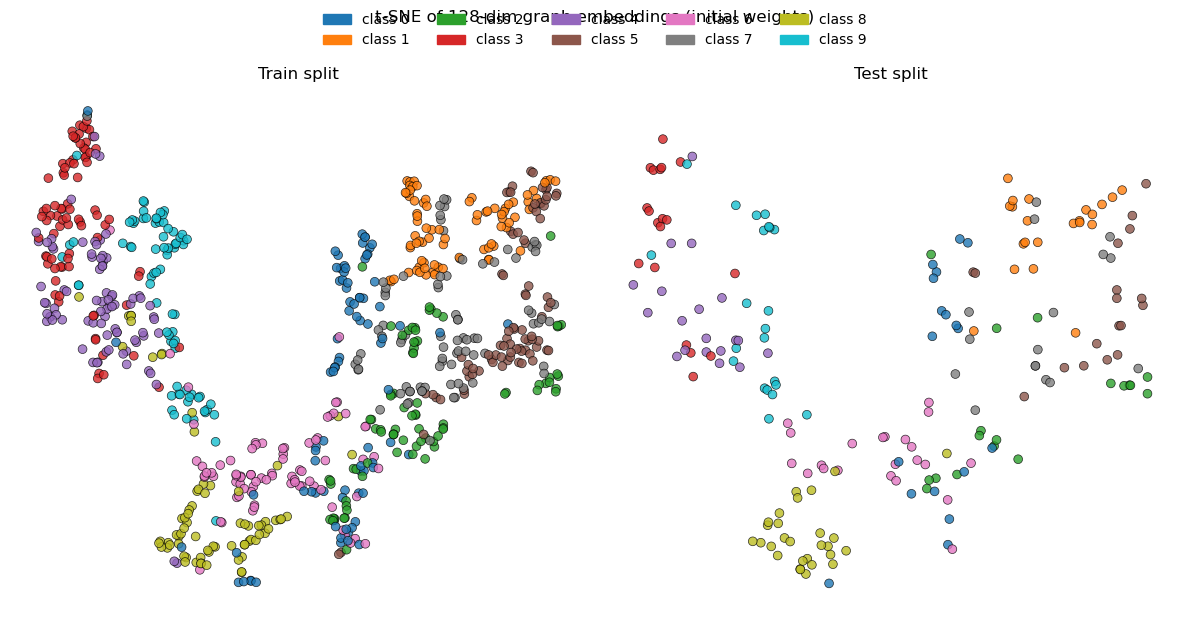

/state/partition1/slurm_tmp/511973.0.0/ipykernel_890555/2101702851.py:191: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.long, device=device)
/state/partition1/slurm_tmp/511973.0.0/ipykernel_890555/2101702851.py:213: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.long, device=device)


Epoch 000 | train loss 2.3007 | train acc 0.132 | test acc 0.153
Epoch 001 | train loss 2.2081 | train acc 0.167 | test acc 0.252
Epoch 002 | train loss 2.0630 | train acc 0.225 | test acc 0.272
Epoch 003 | train loss 1.9176 | train acc 0.256 | test acc 0.277
Epoch 004 | train loss 1.7988 | train acc 0.288 | test acc 0.307
Epoch 005 | train loss 1.7086 | train acc 0.328 | test acc 0.436
Epoch 006 | train loss 1.6570 | train acc 0.322 | test acc 0.411
Epoch 007 | train loss 1.5985 | train acc 0.335 | test acc 0.198
Epoch 008 | train loss 1.5630 | train acc 0.360 | test acc 0.381
Epoch 009 | train loss 1.5409 | train acc 0.333 | test acc 0.307
Epoch 010 | train loss 1.5131 | train acc 0.349 | test acc 0.441
Epoch 011 | train loss 1.4779 | train acc 0.375 | test acc 0.475
Epoch 012 | train loss 1.4563 | train acc 0.391 | test acc 0.446
Epoch 013 | train loss 1.4702 | train acc 0.389 | test acc 0.302
Epoch 014 | train loss 1.4255 | train acc 0.420 | test acc 0.272
Epoch 015 | train loss 1.

In [ ]:
# -----------------------------------------------------------
# 0.  Imports + helpers you already have
# -----------------------------------------------------------
import random, numpy as np, networkx as nx, torch, gymnasium as gym
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch import optim

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
import numpy as np

# ───────── t-SNE plotting helper ───────────────────────────────────
def plot_tsne(train_emb, test_emb, train_lbl, test_lbl, title_suffix=""):
    tsne = TSNE(n_components=2, perplexity=20, init="random", random_state=0)
    all_emb  = torch.cat([train_emb, test_emb], dim=0).numpy()
    xy       = tsne.fit_transform(all_emb)
    n_tr     = train_emb.size(0)

    cmap = plt.get_cmap("tab10", 10)
    fig, (ax_tr, ax_te) = plt.subplots(
        1, 2, figsize=(12, 6), sharex=True, sharey=True, tight_layout=True
    )

    def scat(ax, start, end, labels, title):
        ax.scatter(xy[start:end, 0], xy[start:end, 1],
                   c=labels, cmap=cmap, vmin=0, vmax=9,
                   marker="o", s=40, linewidths=.5,
                   edgecolors="k", alpha=.8)
        ax.set_title(title, fontsize=12);  ax.axis("off")

    scat(ax_tr, 0,        n_tr,  train_lbl.numpy(), "Train split")
    scat(ax_te, n_tr, None, test_lbl.numpy(),  "Test split")

    h = [mpatches.Patch(color=cmap(i), label=f"class {i}") for i in range(10)]
    fig.legend(handles=h, loc="upper center", ncol=5, frameon=False)
    fig.suptitle(f"t-SNE of 128-dim graph embeddings {title_suffix}", y=1.02)
    plt.show()
    
def collect_embeddings(dataloader):
    embs, lbls = [], []
    feature_extractor.eval()
    with torch.no_grad():
        for obs, y in dataloader:
            # move obs to device
            obs = {k: torch.as_tensor(v, dtype=torch.float32, device=device)
                   for k, v in obs.items()}
            emb = feature_extractor(obs)        # shape (B, 128)
            embs.append(emb.cpu())
            lbls.append(torch.tensor(y))        # keep on CPU for t‑SNE
    return torch.cat(embs, dim=0), torch.cat(lbls, dim=0)
# from your_module import (
#     load_graph_pickle,
#     resize_matrix,
#     generate_one_hot_features_from_adj,
#     generate_random_initial_states_multi_input_v2,
#     CustomGCNN,
# )

# -----------------------------------------------------------
# 1.  Parameters
# -----------------------------------------------------------


truth_tables = {
    "0x3AC7": 0,
    "0x1BDE": 1,
    "0x4F93": 2,
    "0x0A5C": 3,
    "0x2CE1": 4,
    "0x5D3F": 5,
    "0x23B9": 6,
    "0x19E7": 7,
    "0x65F0": 8,
    "0x0D4B": 9,
}
per_table      = 100
num_classes    = len(truth_tables)
max_nodes      = 100
node_feat_dim  = 4
batch_size     = 32
train_ratio    = 0.8
epochs         = 300
lr             = 3e-4
device         = "cuda" if torch.cuda.is_available() else "cpu"

# -----------------------------------------------------------
# 2.  Dataset
# -----------------------------------------------------------
class TruthTableDataset(Dataset):
    def __init__(self):
        self.obs, self.labels = [], []
        for circuit_hex, lbl in truth_tables.items():
            path = (
                f"/home/gridsan/spalacios/DRL1/supercloud-testing/"\
                   f"ABC-and-PPO-testing1/Verilog_files_for_all_4_input_1_output_truth_tables_as_NIGs/"\
                   f"{circuit_hex}_NIG_unoptimized.pkl"
            )
            G0 = load_graph_pickle(path)
            states = generate_random_initial_states_multi_input_v2(
                G0, per_table,
                precomputed_graphs_1_input, graphs_library_1_input,
                precomputed_graphs_2_input, graphs_library_2_input,
                precomputed_graphs_3_input, graphs_library_3_input,
                precomputed_graphs_4_input, graphs_library_4_input
            )
            for G in states:
                nodelist   = list(nx.topological_sort(G))
                adj_sparse = nx.adjacency_matrix(G, nodelist=nodelist)
                adj_dense  = adj_sparse.toarray()
                
                adj_matrix = resize_matrix(adj_dense, max_nodes)
                adj_matrix = np.array(adj_matrix, dtype=np.float32)

                node_feat  = generate_one_hot_features_from_adj(adj_sparse, pad_size=max_nodes)
                scalars    = np.zeros(3, dtype=np.float32)

                self.obs.append({
                    "node_features": node_feat.astype(np.float32),
                    "adj_matrix"   : adj_matrix,
                    "scalars"      : scalars,
                })
                self.labels.append(lbl)

    def __len__(self):          return len(self.labels)
    def __getitem__(self, idx): return self.obs[idx], self.labels[idx]

full_ds = TruthTableDataset()

# -----------------------------------------------------------
# 3.  Split + DataLoaders
# -----------------------------------------------------------
train_len = int(len(full_ds) * train_ratio)
test_len  = len(full_ds) - train_len
train_ds, test_ds = random_split(
    full_ds, [train_len, test_len],
    generator=torch.Generator().manual_seed(42)
)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

# -----------------------------------------------------------
# 4.  Model setup
# -----------------------------------------------------------
observation_space = gym.spaces.Dict({
    "node_features": gym.spaces.Box(0,1,shape=(max_nodes,node_feat_dim),dtype=np.float32),
    "adj_matrix"   : gym.spaces.Box(0,1,shape=(max_nodes,max_nodes),dtype=np.float32),
    "scalars"      : gym.spaces.Box(0,1000,shape=(3,),dtype=np.float32),
})



feature_dim = 128
gnn   = CustomGCNN(observation_space, features_dim=feature_dim).to(device)
clf   = nn.Linear(feature_dim, num_classes).to(device)
model = nn.Sequential(gnn, clf)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)



# --------------- BEFORE training loop -----------------
feature_extractor = model[0]

train_emb0, train_lbl0 = collect_embeddings(train_dl)
test_emb0,  test_lbl0  = collect_embeddings(test_dl)

plot_tsne(train_emb0, test_emb0, train_lbl0, test_lbl0,
          title_suffix="(initial weights)")
# ------------------------------------------------------


# -----------------------------------------------------------
# 5.  Train / Eval loops (Option A: inline conversion)
# -----------------------------------------------------------
for epoch in range(epochs):
    # —— Training —— 
    model.train()
    running_loss = correct = total = 0

    for obs, y in train_dl:
        # convert obs dict → tensors on device
        obs = {
            k: torch.as_tensor(v, dtype=torch.float32, device=device)
            for k,v in obs.items()
        }
        y = torch.tensor(y, dtype=torch.long, device=device)

        optimizer.zero_grad()
        logits = model(obs)               # shape (B, num_classes)
        loss   = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * y.size(0)
        preds        = logits.argmax(dim=1)
        correct     += (preds == y).sum().item()
        total       += y.size(0)

    # —— Evaluation —— 
    model.eval()
    test_correct = test_total = 0
    with torch.no_grad():
        for obs, y in test_dl:
            obs = {
                k: torch.as_tensor(v, dtype=torch.float32, device=device)
                for k,v in obs.items()
            }
            y = torch.tensor(y, dtype=torch.long, device=device)

            logits = model(obs)
            test_correct += (logits.argmax(dim=1) == y).sum().item()
            test_total   += y.size(0)

    print(
        f"Epoch {epoch:03d} | "
        f"train loss {running_loss/total:.4f} | "
        f"train acc {correct/total:.3f} | "
        f"test acc {test_correct/test_total:.3f}"
    )




/state/partition1/slurm_tmp/511973.0.0/ipykernel_890555/2101702851.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lbls.append(torch.tensor(y))        # keep on CPU for t‑SNE


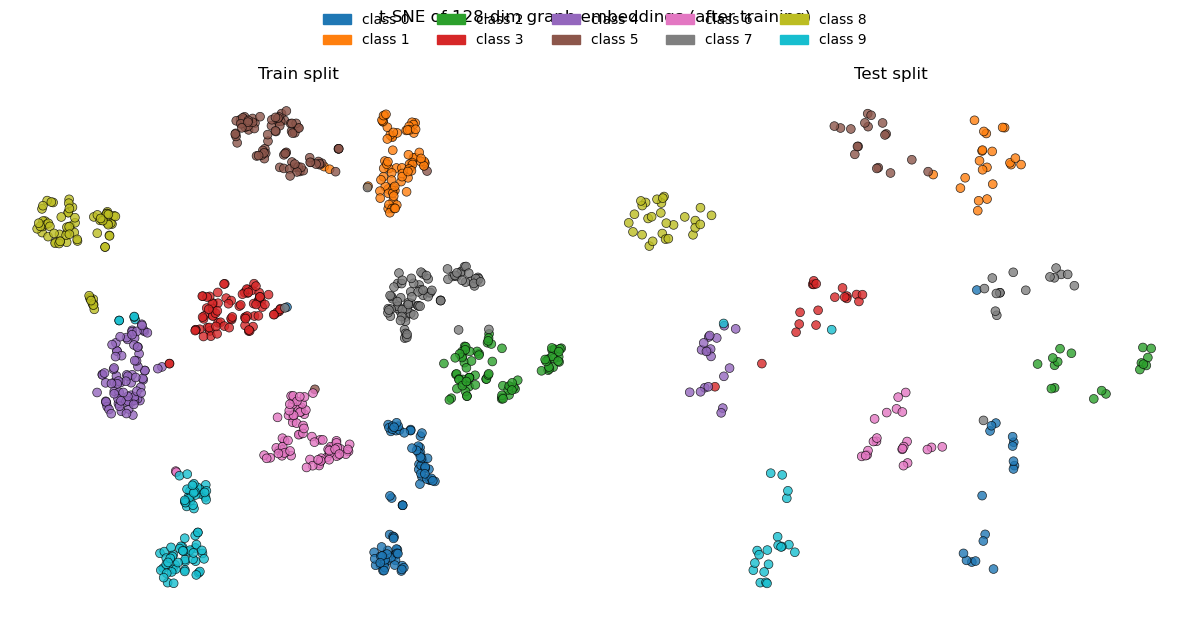

In [6]:
# --------------- AFTER training loop ------------------
train_emb, train_lbl = collect_embeddings(train_dl)
test_emb,  test_lbl  = collect_embeddings(test_dl)

plot_tsne(train_emb, test_emb, train_lbl, test_lbl,
          title_suffix="(after training)")
# ------------------------------------------------------


In [ ]:
# ------------------------------------------------------------
# 0.  Pull out the feature extractor part of your model
# ------------------------------------------------------------
feature_extractor = model[0]          # model = nn.Sequential(gnn, clf)

def collect_embeddings(dataloader):
    embs, lbls = [], []
    feature_extractor.eval()
    with torch.no_grad():
        for obs, y in dataloader:
            # move obs to device
            obs = {k: torch.as_tensor(v, dtype=torch.float32, device=device)
                   for k, v in obs.items()}
            emb = feature_extractor(obs)        # shape (B, 128)
            embs.append(emb.cpu())
            lbls.append(torch.tensor(y))        # keep on CPU for t‑SNE
    return torch.cat(embs, dim=0), torch.cat(lbls, dim=0)

train_emb, train_lbl = collect_embeddings(train_dl)
test_emb,  test_lbl  = collect_embeddings(test_dl)

print("Embeddings ready →  train:", train_emb.shape,
      "| test:", test_emb.shape)


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
import numpy as np

# ── 1) Embed to 2-D ────────────────────────────────────────────────────────────
tsne     = TSNE(n_components=2, perplexity=20, init="random", random_state=0)
all_emb  = torch.cat([train_emb, test_emb], dim=0).numpy()
xy       = tsne.fit_transform(all_emb)
n_tr     = train_emb.size(0)

train_lbl_np = train_lbl.numpy()
test_lbl_np  = test_lbl.numpy()

# ── 2) Prepare the two panels ─────────────────────────────────────────────────
fig, (ax_tr, ax_te) = plt.subplots(
    1, 2, figsize=(12, 6), sharex=True, sharey=True, tight_layout=True
)
cmap = plt.get_cmap("tab10", 10)

def scatter_subset(ax, start, end, labels, title):
    ax.scatter(
        xy[start:end, 0], xy[start:end, 1],
        c=labels, cmap=cmap, vmin=0, vmax=9,
        marker="o", s=40, linewidths=.5, edgecolors="k", alpha=.8
    )
    ax.set_title(title, fontsize=12)
    ax.axis("off")

# left = train, right = test
scatter_subset(ax_tr, 0,        n_tr,  train_lbl_np, "Train split")
scatter_subset(ax_te, n_tr, None, test_lbl_np,  "Test split")

# ── 3) One shared legend for the 10 classes ───────────────────────────────────
class_handles = [mpatches.Patch(color=cmap(i), label=f"class {i}") for i in range(10)]
fig.legend(handles=class_handles, loc="upper center", ncol=5, frameon=False)

fig.suptitle("t-SNE of 128-dim graph embeddings (10 truth tables)", fontsize=14, y=1.02)
plt.show()


In [ ]:
from typing import Optional
import torch, numpy as np, networkx as nx, matplotlib.pyplot as plt

# ------------------------------------------------------------------
# Integrated Gradients for a multi‑class GCNN classifier (10 logits)
# ------------------------------------------------------------------
def integrated_gradients(
    model,
    obs: dict,
    target_class: Optional[int] = None,   # None → use model’s prediction
    steps: int = 40
):
    """
    Compute Integrated Gradients (IG) for *obs* w.r.t. the chosen class logit.

    Returns
    -------
    ig : dict[str, Tensor]  attributions with same keys / shapes as *obs*
    """
    device = next(model.parameters()).device
    baseline   = {k: torch.zeros_like(v) for k, v in obs.items()}
    acc_grads  = {k: torch.zeros_like(v, dtype=torch.float32) for k, v in obs.items()}
    alphas     = torch.linspace(0.0, 1.0, steps + 1, device=device)

    for a in alphas:
        # linear interpolation between baseline and the real input
        interpolated = {k: baseline[k] + a * (obs[k] - baseline[k]) for k in obs}

        # enable gradient tracking
        for t in interpolated.values():
            t.requires_grad_(True)

        model.zero_grad()
        logits = model(interpolated)          # shape (1, 10)

        if target_class is None:
            cls = logits.argmax(dim=1).item()
        else:
            cls = target_class

        scalar_logit = logits[0, cls]         # pick the class to explain
        scalar_logit.backward()

        with torch.no_grad():
            for k in acc_grads:
                if interpolated[k].grad is not None:
                    acc_grads[k] += interpolated[k].grad

    ig = {k: (obs[k] - baseline[k]) * acc_grads[k] / (steps + 1) for k in obs}
    return ig

# ╭─ quick demo on the first test graph ───────────────────────────────╮
if len(test_ds):
    sample_obs, sample_lbl = test_ds[0]           # numpy arrays
    # add batch‑dim and move to GPU/CPU
    obs_t = {
        k: torch.as_tensor(v, dtype=torch.float32, device=device).unsqueeze(0)
        for k, v in sample_obs.items()
    }

    # IG wrt the *predicted* class
    attr = integrated_gradients(model, obs_t, target_class=None, steps=40)

    # node importance = L1 over feature dims
    node_scores = attr["node_features"].abs().sum(-1).squeeze(0).cpu().numpy()

    # trim isolated padding nodes (where row+col sum == 0)
    mask      = (sample_obs["adj_matrix"].sum(0) +
                 sample_obs["adj_matrix"].sum(1)) > 0
    node_scores = node_scores[mask]
    adj_trim     = sample_obs["adj_matrix"][np.ix_(mask, mask)]

    g_vis = nx.from_numpy_array(adj_trim, create_using=nx.DiGraph)
    pos   = nx.spring_layout(g_vis, seed=42)

    vmin, vmax = node_scores.min(), node_scores.max()
    plt.figure(figsize=(4,4))
    nx.draw_networkx_nodes(
        g_vis, pos,
        node_color=node_scores,
        cmap=plt.cm.Reds, vmin=vmin, vmax=vmax,
        node_size=220
    )
    nx.draw_networkx_edges(g_vis, pos, arrows=False, edge_color="#666")
    sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds,
                               norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    plt.colorbar(sm, shrink=0.7,
                 label="Integrated Gradients node importance")
    plt.title("IG heat‑map on a test graph (10‑class model)")
    plt.axis("off")
    plt.show()
# ╰────────────────────────────────────────────────────────────────────╯


In [ ]:



nodelist = list(nx.topological_sort(self.current_solution))
adj_matrix_sparse = nx.adjacency_matrix(self.current_solution, nodelist=nodelist)           
adj_matrix_dense = adj_matrix_sparse.toarray()
adj_matrix = resize_matrix(adj_matrix_dense, self.max_nodes)
adj_matrix = np.array(adj_matrix)        
self.state = adj_matrix        

# Map circuit to observation from the environment
node_features = generate_one_hot_features_from_adj(adj_matrix_sparse, pad_size=self.max_nodes)
scalars = np.array([self.num_inputs, self.num_outputs, self.num_nodes], dtype=np.float32)

observation = {
    "node_features": node_features,
    "adj_matrix": adj_matrix,
    "scalars": scalars
}    

In [ ]:
    # Path to the directory containing all the circuit files
    directory_path = '/home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/Verilog_files_for_all_4_input_1_output_truth_tables_as_NIGs/'

    # Get all .pkl files in the directory that match the pattern
    all_circuit_files = glob.glob(os.path.join(directory_path, '*_NIG_unoptimized.pkl'))

    # Define how many random files you want
    n = 10  # Change this to your desired number

    # Randomly select n files (or all if there are fewer than n files)
    n = min(n, len(all_circuit_files))  # Make sure n is not larger than the total files available
    selected_circuit_files = random.sample(all_circuit_files, n)

    G_initial_states = []
    # Loop over the randomly selected circuit files
    for circuit_file in selected_circuit_files:
        # Extract the circuit hex from the filename
        filename = os.path.basename(circuit_file)
        circuit_hex = filename.split('_')[0]  # Assumes the format is 'HEXVALUE_NIG_unoptimized.pkl'

        # Load the graph
        G = load_graph_pickle(circuit_file)

        # Generate initial states for this circuit
        circuit_states = generate_random_initial_states_multi_input_v2(
            G, 0,
            precomputed_graphs_1_input, graphs_library_1_input,
            precomputed_graphs_2_input, graphs_library_2_input,
            precomputed_graphs_3_input, graphs_library_3_input,
            precomputed_graphs_4_input, graphs_library_4_input
        )

        # Add the states to our collection
        G_initial_states.extend(circuit_states)

        # Optional: Print progress
        print(f"Processed {circuit_hex}, added {len(circuit_states)} states")

    print(f"Processed {n} random files out of {len(all_circuit_files)} total files")
    print(f"Total initial states generated: {len(G_initial_states)}")

In [ ]:
import pickle
import networkx as nx
from networkx.algorithms.graph_hashing import weisfeiler_lehman_graph_hash
from tqdm.auto import tqdm            # ⇐ notebook‑friendly progress bar

# --- 1. Load the dictionary -----------------------------------------------
pkl_path = "graphs_library_4_input_4_3_pruned.pkl"
with open(pkl_path, "rb") as f:
    graphs_dict = pickle.load(f)

print(f"Loaded {len(graphs_dict)} total graphs")

# --- 2. Compute WL hashes with progress bar -------------------------------
hashes: dict[str, list] = {}

for key, G in tqdm(graphs_dict.items(),
                   desc="Hashing graphs",
                   unit="graph"):
    g_hash = weisfeiler_lehman_graph_hash(G, digest_size=16)
    hashes.setdefault(g_hash, []).append(key)

# --- 3. Report results -----------------------------------------------------
n_unique = len(hashes)
print(f"\nUnique isomorphism classes: {n_unique}")

# Optional: inspect hash buckets with >1 graph
for h, keys in hashes.items():
    if len(keys) > 1:
        print(f"Hash {h} → {len(keys)} graphs: {keys}")
